<a href="https://colab.research.google.com/github/Muse-M/FinalYearProject/blob/main/QSO%2BMany_HostGal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# QSO + Many Galaxy Type

## Imports

In [1]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 52.8 MB/s eta 0:00:00


In [25]:
# Pytorch imports
import torch
import torch.utils.data as data
import torch.nn as nn
from torch.utils.tensorboard import SummaryWriter

# General Python imports
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "serif" # Standardise font throughout whole notebook
from   matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import numpy as np
import os
import pandas as pd
import pickle
from datetime import datetime

# Quality of life imports
from tqdm.notebook import tqdm # progress Bar
from accelerate import Accelerator

# data processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter
# Load tensorboard extension for Jupyter Notebook, only need to start TB in the notebook
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [3]:
################UoA code################
torch.manual_seed(42) # Setting the seed

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

# GPU operations have a separate seed we also want to set
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Device cuda


## Dataloader + Visualisation

In [4]:
dataPath='/content/drive/MyDrive/Many QSO + all gal'
filePaths=[]
for i in os.listdir(dataPath):
  filePaths.append(os.path.join(dataPath, i))

In [5]:
from concurrent.futures import ThreadPoolExecutor
def load_pickle(file_path):
    with open(file_path, "rb") as f:
        data = pickle.load(f)
        data['wl'] = data['wl'].flatten()
        df=pd.DataFrame(data)
        df_single_row = pd.DataFrame({col: [df[col].tolist()] for col in df.columns})
        return df_single_row

# Load files in parallel (take 1 minute on collab GPU)
with ThreadPoolExecutor() as executor:
    dataframes = list(executor.map(load_pickle, filePaths))


final_df = pd.concat(dataframes, ignore_index=True)
final_df.shape

(10000, 6)

In [26]:
firstDataset=final_df.copy(deep=True)
firstDataset['f_gal'] = firstDataset['f_gal'].apply(lambda x: x[0])
firstDataset['gal_type'] = firstDataset['gal_type'].apply(lambda x: x[0])

le = LabelEncoder()
firstDataset['gal_type_code'] = le.fit_transform(firstDataset['gal_type'])

In [27]:
display(firstDataset.head())
firstDataset.info()

,wl,flux,true_AGN,true_gal,gal_type,f_gal,gal_type_code
0,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[1.5879516667037834, 1.5875734218403277, 1.590...","[1.5804356054420239, 1.5801577479461435, 1.583...","[0.007516061261759431, 0.007415673894184079, 0...",SF,0.01,2
1,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[0.9886330706453645, 0.9941504273455667, 0.984...","[0.7707842821379141, 0.7766115233167897, 0.772...","[0.21784878850745043, 0.21753890402877699, 0.2...",green,0.43,3
2,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[1.3773286006067391, 1.3804289543271433, 1.372...","[1.2607353268564312, 1.2675884312909873, 1.260...","[0.11659327375030794, 0.112840523036156, 0.112...",PSB,0.20,0
3,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[1.5972932084239753, 1.588366287774871, 1.5859...","[1.5382612681105197, 1.5291207538284406, 1.526...","[0.059031940313455496, 0.05924553394643046, 0....",SB,0.06,1
4,"[3300.654, 3301.4141, 3302.1744, 3302.9348, 33...","[1.0141684137895761, 1.015296388556483, 1.0097...","[0.8181937731146112, 0.8196005169294199, 0.819...","[0.19597464067496487, 0.19569587162706306, 0.1...",green,0.38,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   wl             10000 non-null  object 
 1   flux           10000 non-null  object 
 2   true_AGN       10000 non-null  object 
 3   true_gal       10000 non-null  object 
 4   gal_type       10000 non-null  object 
 5   f_gal          10000 non-null  float64
 6   gal_type_code  10000 non-null  int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 547.0+ KB


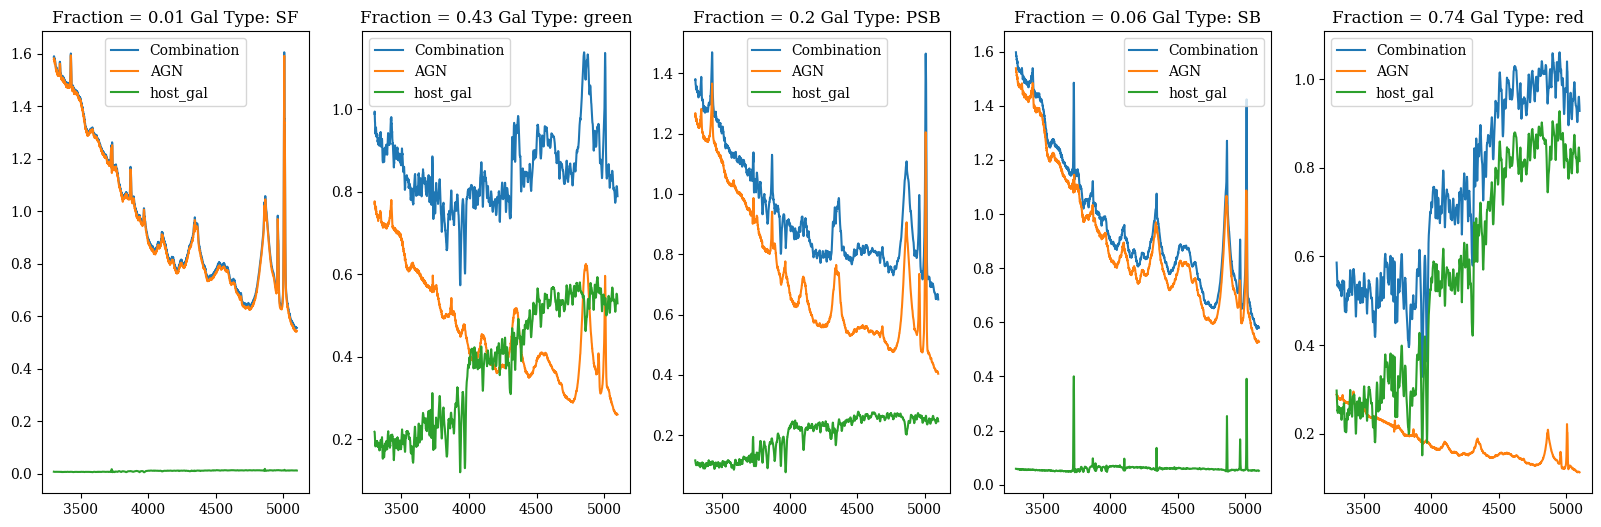

In [28]:
# Example datum
fig, ax = plt.subplots(figsize=(20,6), ncols=5)
uniqueType=[]
i=0
graph=0
while len(uniqueType) < 5:
  singleRow=firstDataset.iloc[[i]]
  wl= singleRow['wl'].iloc[0]
  flux= singleRow['flux'].iloc[0]
  true_AGN= singleRow['true_AGN'].iloc[0]
  true_gal= singleRow['true_gal'].iloc[0]
  gal_type=singleRow['gal_type'].iloc[0]
  f_gal= singleRow['f_gal'].iloc[0]
  i+=1
  if gal_type in uniqueType:
    pass
  else:
    ax[graph].plot(wl, flux, label='Combination')
    ax[graph].plot(wl, true_AGN, label='AGN')
    ax[graph].plot(wl, true_gal, label='host_gal')
    ax[graph].set_title('Fraction = '+str(f_gal)+ ' Gal Type: '+ gal_type)
    ax[graph].legend()
    graph+=1
    uniqueType.append(gal_type)

<Axes: >

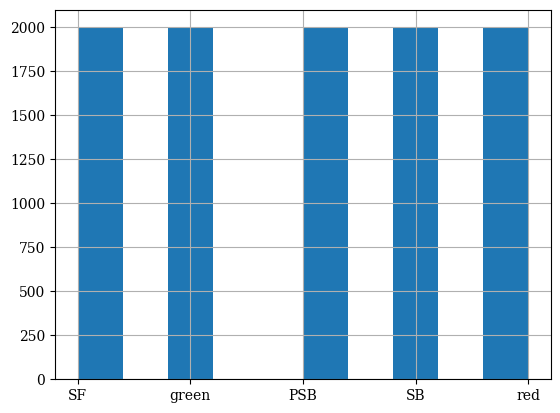

In [42]:
firstDataset['gal_type'].hist()

<Axes: >

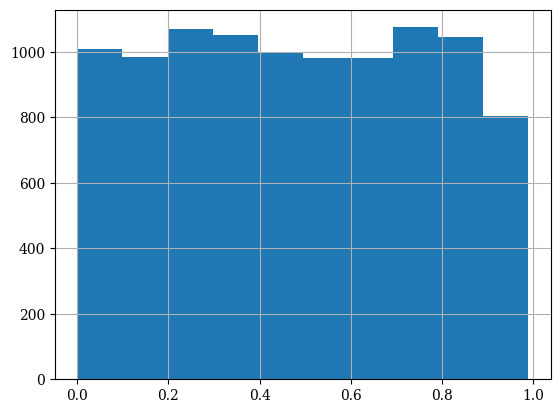

In [43]:
firstDataset['f_gal'].hist()

In [29]:
# Dataset class
class tensorData(data.Dataset):
  def __init__(self, flux, fraction, galTypeCode):
    self.data=flux
    self.label=fraction
    self.galTypeCode=galTypeCode
    self.generateData()
    self.size=len(self.data)

  def generateData(self):
    self.tensordata=torch.Tensor(self.data)
    self.tensorlabel=torch.Tensor(self.label)
    self.tensorGalTypeCode=torch.Tensor(self.galTypeCode)

  # define __getitem__, and __len__ to define pytorch dataset, allows you use dataset[index] wihout needed to do dataset.getitem(index)
  def __getitem__(self, index):
    data_point = self.tensordata[index]
    data_label = self.tensorlabel[index]
    gal_typeCode = self.tensorGalTypeCode[index]
    return data_point, data_label, gal_typeCode

  def  __len__(self):
    return self.size

fullDataset=tensorData(firstDataset['flux'], firstDataset['f_gal'], firstDataset['gal_type_code'])

In [30]:
trainDataset, testDataset = torch.utils.data.random_split(fullDataset, [9000,1000])
trainDataset, validDataset = torch.utils.data.random_split(trainDataset, [8800,200])

In [31]:
train_data_loader = data.DataLoader(trainDataset, batch_size=40, num_workers=0, pin_memory=False ,shuffle=True)
valid_data_loader = data.DataLoader(validDataset, batch_size=100, shuffle=True)
test_data_loader = data.DataLoader(testDataset, batch_size=500, shuffle=True)

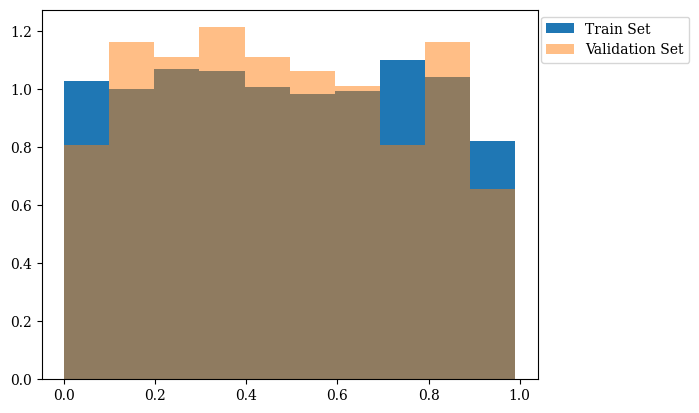

In [40]:
_=plt.hist(trainDataset[:][1],10, density=True, label='Train Set')
_=plt.hist(validDataset[:][1],10, density=True, alpha=0.5, label='Validation Set')
plt.legend(bbox_to_anchor =(0,0,1.32,1))

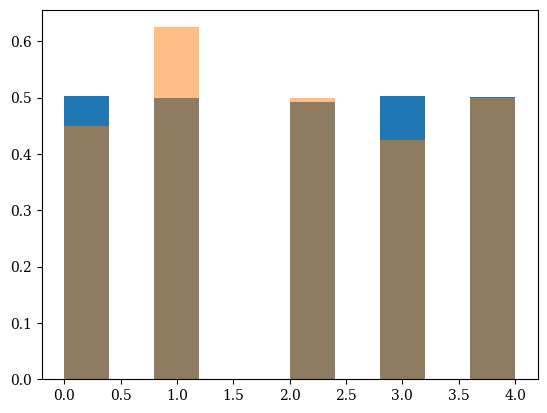

In [61]:
_=plt.hist(trainDataset[:][2], bins=10, density=True)
_=plt.hist(validDataset[:][2], bins=10, density=True, alpha=0.5)

## Training and Graphing

- bring in training function from alex net and graph_alex function from alex net.
- edit graph function to take in gal type and a boolean to decide to colour based on gal type
- bring in resnet 50 ONLY first. Quick model to make sure it works and a gridsearch to finish the day